# **Access to the drive**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/homework2

/gdrive/My Drive/homework2


# **Import libraries**

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import warnings
import logging
from scipy import signal
from scipy.fft import fftshift

#from tsaug.visualization import plot

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


# **Set the seed**

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# **Dataset**

In [ ]:
# Unzip the dataset (on the disk)
!unzip dataset_homework2.zip -d dataset

In [5]:
# Set dataset dir
dataset_dir = 'dataset'

In [6]:
# load to RAM from disk
X = np.load(os.path.join(dataset_dir, 'X.npy'))
print("Found {} X:".format(len(X)))
print(X.shape)
print(X)

y = np.load(os.path.join(dataset_dir, 'y.npy'))
print("Found {} y:".format(len(y)))
print(y.shape)
print(y)

Found 2429 X:
(2429, 36, 6)
[[[ 1.7597e+01  8.1713e+00 -1.7842e+00 -1.9706e+01 -9.7135e+00
   -6.1887e+01]
  [ 2.2974e-01 -5.8956e+00  1.6837e+01  5.0390e+00  2.4332e+00
    5.8914e+01]
  [-2.9654e+01 -2.1296e+01  2.9103e+01 -4.7503e-01  7.5391e+01
    1.0665e+01]
  ...
  [ 1.1982e+02  2.1849e+02  1.6398e+03  5.9787e+02  2.1922e+03
    1.8484e+01]
  [ 9.1591e+01  1.0378e+02  1.8238e+03  1.2460e+03  1.1301e+04
    7.5107e+02]
  [ 4.3719e+01  3.0689e+01  9.5092e+02  8.5927e+02  8.1331e+03
    9.8883e+02]]

 [[ 2.4209e+00 -5.6039e-01  2.3654e+01 -3.8171e+00  1.3721e+00
    8.2510e+00]
  [ 1.6847e+00  2.3989e+01  1.7803e+01 -1.9575e+01 -8.2534e+00
   -2.3959e+01]
  [ 5.0692e-01  5.0281e+01  5.1196e+01  1.6036e+01  7.2974e-01
   -1.8185e+01]
  ...
  [-1.5618e+01 -7.4233e+00  3.7833e+00  1.6565e+00 -1.0438e+01
   -5.5229e+00]
  [-1.0702e+01 -6.3568e+00 -4.6464e+00  6.7957e-01 -5.5260e+00
    1.9070e+01]
  [-4.6352e+00 -3.2769e+00 -5.9048e+00 -1.9564e-01  1.1487e+00
    2.3275e+01]]

 [[ 3.96

36 6
0        0
1        0
2        0
3        0
4        0
        ..
2424    11
2425    11
2426    11
2427    11
2428    11
Length: 2429, dtype: int32
0      34
1     123
2     270
3     381
4      62
5     153
6     313
7      68
8     120
9     777
10     77
11     51
dtype: int64


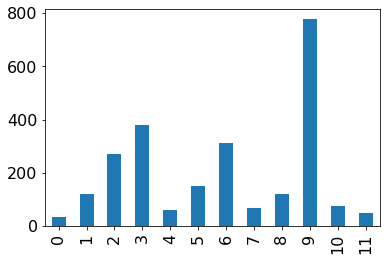

In [7]:
sequence_length, num_features = X.shape[1:]
print(sequence_length, num_features)

print(pd.Series(y))
y_series = pd.Series(y)
# count how many things there are for classes
print(y_series.value_counts().sort_index())
y_series.value_counts().sort_index().plot.bar()

In [8]:
# Split the dataset using train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [9]:
# Inspect the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1700, 36, 6), (729, 36, 6), (1700,), (729,))

# **Paths**


In [10]:
# Create path
Model1 = "diego_model/SubmissionModel/BiLSTM_data_dup_prepro.h5"
Model2 = "giulia_model/SubmissionModel"

path_scaler_1 = "diego_model"
path_scaler_2 = "giulia_model"

# **Build ensemble model**

In [11]:
#Initiating the usage of individual models

import pickle

keras_model1 = tf.keras.models.load_model(Model1, compile=False) 
keras_model1._name = 'Model1'

keras_model2 = tf.keras.models.load_model(Model2, compile=False) 
keras_model2._name = 'Model2'

models = [keras_model1, keras_model2] 

model_input_1 = tf.keras.Input(shape=[36,6])
model_input_2 = tf.keras.Input(shape=[36,6])

model_outputs = [
      keras_model1(model_input_1),
      keras_model2(model_input_2)
]

ensemble_output = tf.keras.layers.Average()(model_outputs) #averaging outputs
enens_model = tf.keras.Model(inputs=[model_input_1, model_input_2], outputs=ensemble_output)

enens_model.summary() #prints a comprehensive summary of the Keras model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 Model1 (Functional)            (None, 12)           566924      ['input_1[0][0]']                
                                                                                                  
 Model2 (Functional)            (None, 12)           510988      ['input_2[0][0]']                
                                                                                              

# **Preprocess**

In [16]:
with open(os.path.join("giulia_model", "rscaler.pkl"), "rb") as file:
  scaler_g = pickle.load(file)
with open(os.path.join("diego_model", "rscaler.pkl"), "rb") as file:
  scaler_d = pickle.load(file)

In [17]:
# preprocess modello giulia
def preprocess(X, scaler, val_min, val_max):
    X_clipped = X.clip(val_min, val_max)
    num_examples, sequence_length, num_features = X.shape
    X_standardized = scaler.transform(X_clipped.reshape([-1, num_features])).reshape([num_examples, sequence_length, num_features])
    return X_standardized, scaler

In [19]:
sequence_length, num_features = X.shape[1:]
val_min, val_max = -2000, 2000
X_g, _ = preprocess(X_test, scaler_g, val_min, val_max)

In [26]:
# preprocess modello diego
X_d = scaler_d.transform(tf.reshape(X_test, [-1, num_features])).reshape([len(X_test), sequence_length, num_features])

# **Compile the model**

In [28]:
# Compile the model
enens_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

# **Evaluate and predict**

In [29]:
# Evaluate on test
enens_model_metrics = enens_model.evaluate([X_d, X_g], y_test, return_dict=True)

print()
print("Test metrics enens_model_metrics")
print(enens_model_metrics)

23/23 [==============================] - 6s 102ms/step - loss: 0.3611 - accuracy: 0.8820

Test metrics enens_model_metrics
{'loss': 0.36105117201805115, 'accuracy': 0.882030189037323}


In [31]:
predictions = enens_model.predict([X_d, X_g])

23/23 [==============================] - 5s 105ms/step


In [34]:
predictions.shape

(729, 12)

# **Confusion Matrix**

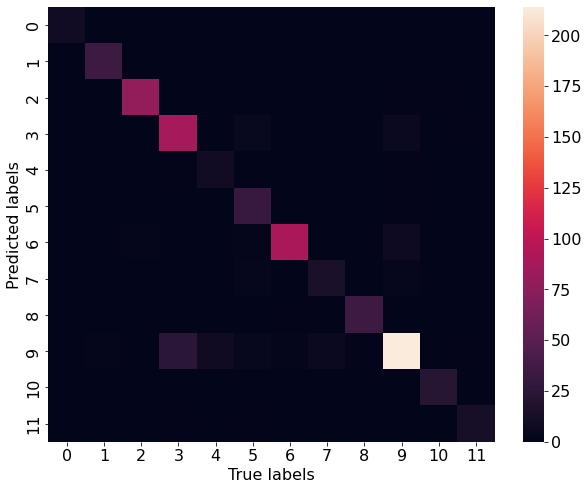

In [47]:
#Create and plot the confusion matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, np.argmax(predictions, axis=-1))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [49]:
#Here we compute accuracy, precision, recall and f1
accuracy = accuracy_score(y_test, np.argmax(predictions, axis=-1))
precision = precision_score(y_test, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(y_test, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(y_test, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.882
Precision: 0.9097
Recall: 0.8575
F1: 0.8777


# **Save the model**

In [ ]:
enens_model.save('Ensemble_model')